In [1]:
import findspark
import pandas as pd
import pylab as pl
import matplotlib.pyplot as plt
import seaborn as sns
findspark.init()

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

In [3]:
spark = (SparkSession.builder.appName("RFM Analysis")
         .config("spark.driver.extraJavaOptions", f"-Dlog4j.configuration=file:/Users/bses/spark/conf/log4j.properties")
         .getOrCreate())
spark

In [4]:
schema = StructType([
    StructField("InvoiceNo", StringType(), True),
    StructField('StockCode', StringType(), True),
    StructField("Description", StringType(), True),
    StructField("Quantity", IntegerType(), True),
    StructField("InvoiceDate", StringType(), True),
    StructField("UnitPrice", FloatType(), True),
    StructField("CustomerID", StringType(), True),
    StructField("COuntry", StringType(), True),
])
df = spark.read.csv('dataset.csv',header=True, schema=schema)

In [5]:
df.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: float (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- COuntry: string (nullable = true)



In [6]:
df.show(5)

+---------+---------+--------------------+--------+----------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|     InvoiceDate|UnitPrice|CustomerID|       COuntry|
+---------+---------+--------------------+--------+----------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|01/12/2010 08:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|01/12/2010 08:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|01/12/2010 08:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|01/12/2010 08:26|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|01/12/2010 08:26|     3.39|     17850|United Kingdom|
+---------+---------+--------------------+--------+----------------+---------+----------+--------------+
only showing top 5 rows



In [7]:
df.count()

541909

In [8]:
df.select('CustomerID').distinct().count()

4373

In [9]:
spark.sql('set spark.sql.legacy.timeParserPolicy=LEGACY')
df = df.withColumn('Date',to_timestamp("InvoiceDate",'dd/MM/yyyy HH:mm'))

In [10]:
df.show(5)

+---------+---------+--------------------+--------+----------------+---------+----------+--------------+-------------------+
|InvoiceNo|StockCode|         Description|Quantity|     InvoiceDate|UnitPrice|CustomerID|       COuntry|               Date|
+---------+---------+--------------------+--------+----------------+---------+----------+--------------+-------------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|01/12/2010 08:26|     2.55|     17850|United Kingdom|2010-12-01 08:26:00|
|   536365|    71053| WHITE METAL LANTERN|       6|01/12/2010 08:26|     3.39|     17850|United Kingdom|2010-12-01 08:26:00|
|   536365|   84406B|CREAM CUPID HEART...|       8|01/12/2010 08:26|     2.75|     17850|United Kingdom|2010-12-01 08:26:00|
|   536365|   84029G|KNITTED UNION FLA...|       6|01/12/2010 08:26|     3.39|     17850|United Kingdom|2010-12-01 08:26:00|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|01/12/2010 08:26|     3.39|     17850|United Kingdom|2010-12-01 08:26:00|


In [11]:
df.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: float (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- COuntry: string (nullable = true)
 |-- Date: timestamp (nullable = true)



In [12]:
df = df.withColumn('FromDate',lit("01/12/2010 08:26"))
df = df.withColumn('FromDate',to_timestamp("FromDate","dd/MM/yyyy HH:mm"))

In [13]:
df2 = df.withColumn('Recency',col("Date").cast("long") - col('FromDate').cast("long"))

In [14]:
df2.show(5)

+---------+---------+--------------------+--------+----------------+---------+----------+--------------+-------------------+-------------------+-------+
|InvoiceNo|StockCode|         Description|Quantity|     InvoiceDate|UnitPrice|CustomerID|       COuntry|               Date|           FromDate|Recency|
+---------+---------+--------------------+--------+----------------+---------+----------+--------------+-------------------+-------------------+-------+
|   536365|   85123A|WHITE HANGING HEA...|       6|01/12/2010 08:26|     2.55|     17850|United Kingdom|2010-12-01 08:26:00|2010-12-01 08:26:00|      0|
|   536365|    71053| WHITE METAL LANTERN|       6|01/12/2010 08:26|     3.39|     17850|United Kingdom|2010-12-01 08:26:00|2010-12-01 08:26:00|      0|
|   536365|   84406B|CREAM CUPID HEART...|       8|01/12/2010 08:26|     2.75|     17850|United Kingdom|2010-12-01 08:26:00|2010-12-01 08:26:00|      0|
|   536365|   84029G|KNITTED UNION FLA...|       6|01/12/2010 08:26|     3.39|    

In [15]:
df2 = df2.join(df2.groupBy('CustomerID').agg(max('Recency').alias('Recency')), on = 'Recency', how = 'leftsemi')

In [16]:
df2.show(5)

+-------+---------+---------+--------------------+--------+----------------+---------+----------+--------------+-------------------+-------------------+
|Recency|InvoiceNo|StockCode|         Description|Quantity|     InvoiceDate|UnitPrice|CustomerID|       COuntry|               Date|           FromDate|
+-------+---------+---------+--------------------+--------+----------------+---------+----------+--------------+-------------------+-------------------+
|   5220|   536384|    82484|WOOD BLACK BOARD ...|       3|01/12/2010 09:53|     6.45|     18074|United Kingdom|2010-12-01 09:53:00|2010-12-01 08:26:00|
|   5220|   536384|    84755|COLOUR GLASS T-LI...|      48|01/12/2010 09:53|     0.65|     18074|United Kingdom|2010-12-01 09:53:00|2010-12-01 08:26:00|
|   5220|   536384|    22464|HANGING METAL HEA...|      12|01/12/2010 09:53|     1.65|     18074|United Kingdom|2010-12-01 09:53:00|2010-12-01 08:26:00|
|   5220|   536384|    21324|HANGING MEDINA LA...|       6|01/12/2010 09:53|     2

In [17]:
df_freq = df2.groupBy('CustomerID').agg(count('InvoiceNo').alias('Frequency'))

In [18]:
df3 = df2.join(df_freq, on = 'CustomerID', how = 'inner')

In [19]:
df_money = df3.withColumn('Money', col('Quantity') * col('UnitPrice')) 

df_money = df_money.groupby('CustomerID').agg(sum('Money').alias('Monetary'))

In [20]:
final =df_money.join(df3, on = 'CustomerID', how = 'inner') 

In [21]:
final.show()

+----------+-----------------+-------+---------+---------+--------------------+--------+----------------+---------+--------------+-------------------+-------------------+---------+
|CustomerID|         Monetary|Recency|InvoiceNo|StockCode|         Description|Quantity|     InvoiceDate|UnitPrice|       COuntry|               Date|           FromDate|Frequency|
+----------+-----------------+-------+---------+---------+--------------------+--------+----------------+---------+--------------+-------------------+-------------------+---------+
|     17714|            153.0|4586760|   541837|    21494|ROTATING LEAVES T...|      12|23/01/2011 10:32|     1.25|United Kingdom|2011-01-23 10:32:00|2010-12-01 08:26:00|       10|
|     17714|            153.0|4586760|   541837|    84347|ROTATING SILVER A...|       6|23/01/2011 10:32|     2.55|United Kingdom|2011-01-23 10:32:00|2010-12-01 08:26:00|       10|
|     17714|            153.0|4586760|   541837|   85036B|CHOCOLATE 1 WICK ...|      12|23/01/2

In [22]:
final_df = final.select(['CustomerID','Monetary','Recency','Frequency']).distinct()
final_df.show(10)

+----------+------------------+-------+---------+
|CustomerID|          Monetary|Recency|Frequency|
+----------+------------------+-------+---------+
|     17714|             153.0|4586760|       10|
|     17551| 306.8399999141693|1230360|       43|
|     13187|236.01999950408936|3148260|       37|
|     15052|215.78000164031982|4692360|       30|
|     17128|157.09000182151794|3382560|       14|
|     14439|2661.2399587631226|4677180|       32|
|     18106| 430.6999933719635|3815820|       39|
|     17855|208.97000122070312|  91080|       17|
|     12386|             143.0|3125460|        2|
|     13065| 205.8600034713745|  30360|       14|
+----------+------------------+-------+---------+
only showing top 10 rows



In [23]:


assemble=VectorAssembler(inputCols=[
    'Recency','Frequency','Monetary'
], outputCol='Features')

assembled_data=assemble.transform(final_df)

scale=StandardScaler(inputCol='Features',outputCol='Standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)

In [38]:
assembled_data.show(4839)

+----------+--------------------+--------+---------+--------------------+
|CustomerID|            Monetary| Recency|Frequency|            Features|
+----------+--------------------+--------+---------+--------------------+
|     17714|               153.0| 4586760|       10|[4586760.0,10.0,1...|
|     17551|   306.8399999141693| 1230360|       43|[1230360.0,43.0,3...|
|     13187|  236.01999950408936| 3148260|       37|[3148260.0,37.0,2...|
|     15052|  215.78000164031982| 4692360|       30|[4692360.0,30.0,2...|
|     17128|  157.09000182151794| 3382560|       14|[3382560.0,14.0,1...|
|     14439|  2661.2399587631226| 4677180|       32|[4677180.0,32.0,2...|
|     18106|   430.6999933719635| 3815820|       39|[3815820.0,39.0,4...|
|     17855|  208.97000122070312|   91080|       17|[91080.0,17.0,208...|
|     12386|               143.0| 3125460|        2|[3125460.0,2.0,14...|
|     13065|   205.8600034713745|   30360|       14|[30360.0,14.0,205...|
|     16510|  248.09999752044678|  105

In [32]:
data_scale_output.select('standardized').show(20,0)

+---------------------------------------------------------------+
|standardized                                                   |
+---------------------------------------------------------------+
|[0.5258889381294404,0.25819728443703055,0.05473295544639634]   |
|[0.14106530839131287,1.1102483230792315,0.10976640551944108]   |
|[0.3609596116551535,0.9553299524170131,0.0844318439040249]     |
|[0.5379963673096174,0.7745918533110917,0.07719135435296048]    |
|[0.38782297014867134,0.3614761982118428,0.05619607889393113]   |
|[0.5362559243649669,0.8262313101984978,0.9520099875500107]     |
|[0.4374978258930228,1.0069694093044192,0.15407505586922143]    |
|[0.010442657667902708,0.438935383542952,0.07475520108788322]   |
|[0.3583455076276153,0.051639456887406114,0.051155638096958674] |
|[0.003480885889300903,0.3614761982118428,0.07364265619734468]  |
|[0.01205927463230135,0.33565646976813973,0.08875324255253371]  |
|[0.12097798270601913,1.368445607516262,0.08944724334351391]    |
|[0.429559

In [25]:
cost = np.zeros(10)

evaluator = ClusteringEvaluator(predictionCol='Prediction', featuresCol='Standardized',metricName='silhouette', distanceMeasure='squaredEuclidean')

for i in range(2,10):
    KMeans_algo=KMeans(featuresCol='Standardized', k=i)
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    output=KMeans_fit.transform(data_scale_output)
    cost[i] = KMeans_fit.summary.trainingCost

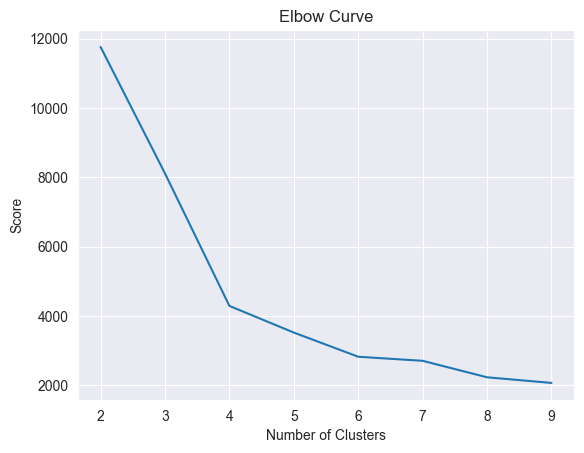

In [26]:
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = range(2,10)
df_cost.insert(0, 'cluster', new_col)
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

In [27]:
KMeans_algo=KMeans(featuresCol='Standardized', k=4)
KMeans_fit=KMeans_algo.fit(data_scale_output)

In [46]:
preds=KMeans_fit.transform(data_scale_output)

temp = preds.filter(preds['prediction']==1)

temp.show()

+----------+------------------+--------+---------+--------------------+--------------------+----------+
|CustomerID|          Monetary| Recency|Frequency|            Features|        Standardized|prediction|
+----------+------------------+--------+---------+--------------------+--------------------+----------+
|     14796|1122.7499933168292|32166300|      199|[3.21663E7,199.0,...|[3.68798484127205...|         1|
|     14796|1122.7499933168292|30344640|      199|[3.034464E7,199.0...|[3.47912480869287...|         1|
|     14796|1122.7499933168292| 4670760|      199|[4670760.0,199.0,...|[0.53551984770458...|         1|
|     12567|3078.2199850082397|30335760|      144|[3.033576E7,144.0...|[3.47810668396636...|         1|
|     12748|1242.4399949610233|32241240|      176|[3.224124E7,176.0...|[3.69657698845730...|         1|
|     12748|1242.4399949610233|30945840|      176|[3.094584E7,176.0...|[3.54805460436638...|         1|
|     12748|1242.4399949610233|30864660|      176|[3.086466E7,17

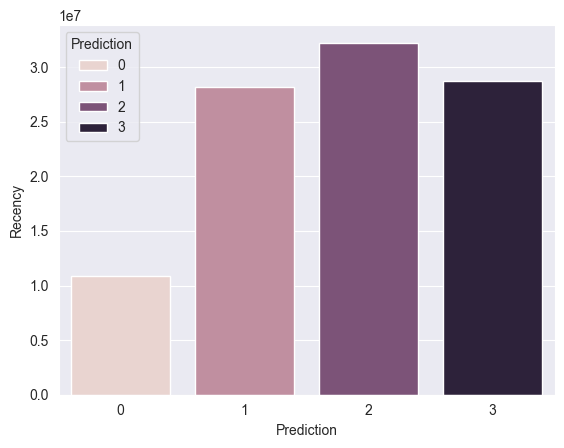

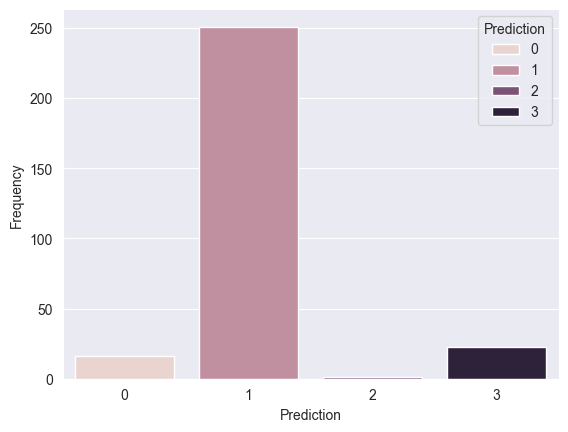

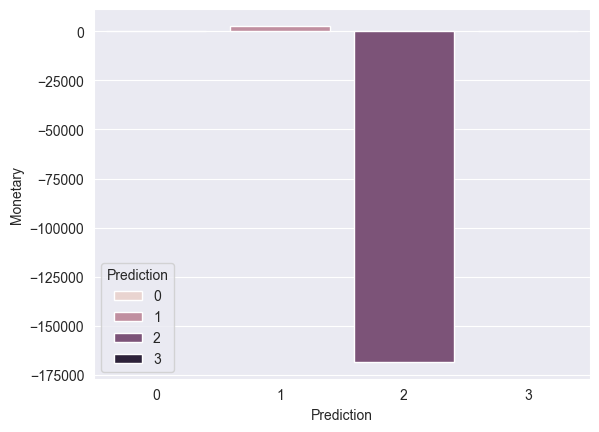

In [29]:
df_viz = preds.select('Recency','Frequency','Monetary','Prediction')
df_viz = df_viz.toPandas()
avg_df = df_viz.groupby(['Prediction'], as_index=False).mean()

list1 = ['Recency','Frequency','Monetary']

for i in list1:
    sns.barplot(x='Prediction',y=str(i),data=avg_df, hue = 'Prediction')
    plt.show()

In [42]:
avg_df

,Prediction,Recency,Frequency,Monetary
0,0,1.087692e+07,16.462171,224.106485
1,1,2.821099e+07,250.766234,2769.031030
2,2,3.223086e+07,1.000000,-168469.593750
3,3,2.876006e+07,22.373202,397.304581
